In [44]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import recall_score, precision_score, f1_score
from keras.layers import (Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D)
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [35]:
# prepare empty dictionary to store dataset (path, label, duration)
dataset = {
    "paths": [],
    "labels": [],
    "durations": []
}

# walk through the path and append the data to the dictionary
for dirname, _, filenames in os.walk("dataset"):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        dataset["paths"].append(path)

        label = filename.split("-")[0]
        dataset["labels"].append(label)

        duration = round(librosa.get_duration(path = path), 4)
        dataset["durations"].append(duration)

In [36]:
mfccs = []

# loop through the dataframe and create mfccs from the audio
for path in dataset["paths"]:
    y, sr = librosa.load(path, sr = 22550)
    mfcc = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 30)
    mfccs.append(mfcc)

In [37]:
resized_mfccs = []

def resize_mfcc(array):
    # create empty array with shape (30, 110)
    new_mfcc = np.zeros((30, 110))
    # loop through the array and copy the value to the new array
    # if the mfcc length less than 110, the rest of the array will be filled with 0
    # if the mfcc length more than 110, the rest of the array will be ignored
    for i in range(30):
        for j in range(110):
            try:
                new_mfcc[i][j] = array[i][j]
            except IndexError:
                pass
    
    # return the new resized mfcc
    return new_mfcc

for mfcc in mfccs:
    resized_mfccs.append(resize_mfcc(mfcc))

In [38]:
def make_train_test_split(x, y):
    y = y.copy()
    # replace string label with number
    for i in range(len(y)):
        if y[i] == "sad": y[i] = 0
        elif y[i] == "happy": y[i] = 1

    # copy the dataset input
    x = x.copy()

    # split the dataset into train and test set (80:20)
    x_tr, x_te, y_tr, y_te = train_test_split(x, y, train_size = 0.8, shuffle = True, random_state = 0)
    # split the train set into train and validation set (80:20)
    x_tr, x_va, y_tr, y_va = train_test_split(x_tr, y_tr, test_size = 0.2, shuffle = True, random_state = 0)

    # convert the dataset into numpy array
    x_tr = np.array([i for i in x_tr])
    x_va = np.array([i for i in x_va])
    x_te = np.array([i for i in x_te])

    # get the mean and standard deviation of the train set
    tr_mean = np.mean(x_tr, axis = 0)
    tr_std = np.std(x_tr, axis = 0)

    # normalize the dataset
    x_tr = (x_tr - tr_mean) / tr_std
    x_va = (x_va - tr_mean) / tr_std
    x_te = (x_te - tr_mean) / tr_std

    # add channel dimension to the dataset
    x_tr = x_tr[..., None]
    x_va = x_va[..., None]
    x_te = x_te[..., None]

    # return the splitted dataset
    return x_tr, y_tr, x_va, y_va, x_te, y_te, tr_mean, tr_std

x_tr, y_tr, x_va, y_va, x_te, y_te, tr_mean, tr_std = make_train_test_split(resized_mfccs, dataset["labels"])

In [39]:

# function to create the model (CNN)
def create_model(x_tr):
    # create sequential model from keras
    model = keras.Sequential()
    # add first convolutional layer, max pooling layer, and batch normalization layer
    model.add(Conv2D(filters = 64, kernel_size = 5, strides = (2, 2), activation = "tanh", input_shape = x_tr.shape[1:]))
    model.add(MaxPool2D(pool_size = 2))
    model.add(BatchNormalization())
    # add second convolutional layer, max pooling layer, and batch normalization layer
    model.add(Conv2D(filters = 32, kernel_size = 4, strides = (2, 1), activation = "tanh"))
    model.add(MaxPool2D(pool_size = 2))
    model.add(BatchNormalization())
    # add flatten layer
    model.add(Flatten())
    # add first dense layer, dropout layer
    model.add(Dropout(0.5))
    model.add(Dense(128, activation = "relu"))
    # add second dense layer, dropout layer
    model.add(Dropout(0.5))
    model.add(Dense(64, activation = "relu"))
    # add third dense layer, dropout layer
    model.add(Dropout(0.5))
    model.add(Dense(units = 2, activation = "sigmoid"))

    # show the summary of the model
    model.summary()

    # return the model
    return model

In [40]:
def train(x_tr, y_tr, x_va, y_va, epoch, batch_size, learning_rate):
    # create the model
    model = create_model(x_tr)
    # prepare the Adam optimizer
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    # compile the model
    model.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

    # prepare early stopping callback
    earlystopping_cb = keras.callbacks.EarlyStopping(patience = 5)

    # train the model
    history = model.fit(
        x = np.asarray(x_tr),
        y = np.asarray(y_tr),
        epochs = epoch,
        batch_size = batch_size,
        validation_data = (np.asarray(x_va), np.asarray(y_va)),
        callbacks = [earlystopping_cb]
    )

    # return the model and history
    return model, history

train_hyperparameter = {
    "epoch": [50, 100],
    "batch_size": [64, 128],
    "learning_rate": [0.001, 0.01],
}

train_result = {
    "epoch": [],
    "batch_size": [],
    "learning_rate": [],
    "accuracy": [],
    "val_accuracy": [],
    "loss": [],
    "val_loss": [],
}

for e in train_hyperparameter["epoch"]:
    for b in train_hyperparameter["batch_size"]:
        for l in train_hyperparameter["learning_rate"]:
            model, history = train(x_tr, y_tr, x_va, y_va, e, b, l)
            joblib.dump(model, f"model_{e}_{b}_{l}.joblib")
            train_result["epoch"].append(e)
            train_result["batch_size"].append(b)
            train_result["learning_rate"].append(l)
            train_result["accuracy"].append(np.mean(history.history["accuracy"][-3:]))
            train_result["val_accuracy"].append(np.mean(history.history["val_accuracy"][-3:]))
            train_result["loss"].append(np.mean(history.history["loss"][-3:]))
            train_result["val_loss"].append(np.mean(history.history["val_loss"][-3:]))

result_pd = pd.DataFrame(train_result)
result_pd

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 13, 53, 64)        1664      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 6, 26, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_22 (Bat  (None, 6, 26, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 2, 23, 32)         32800     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 1, 11, 32)        0         
 g2D)                                                            
                                                     

,epoch,batch_size,learning_rate,accuracy,val_accuracy,loss,val_loss
0,50,64,0.001,0.913542,0.851042,0.210227,0.339946
1,50,64,0.010,0.902083,0.842708,0.248580,0.441923
2,50,128,0.001,0.895052,0.806250,0.257930,0.417920
3,50,128,0.010,0.914062,0.851042,0.227586,0.424495
4,100,64,0.001,0.938542,0.858333,0.162239,0.380261
5,100,64,0.010,0.888021,0.854167,0.285735,0.419266
6,100,128,0.001,0.898698,0.794792,0.242091,0.433788
7,100,128,0.010,0.917188,0.850000,0.212462,0.376208


In [42]:
best_model_index = result_pd["val_accuracy"].idxmax()
best_model_index

4

In [60]:
# function to test the model
def test(model, x_te, y_te):
    # evaluate the model
    loss_te, accuracy_te = model.evaluate(np.asarray(x_te), np.asarray(y_te))

    # return the loss and accuracy
    return loss_te, accuracy_te

# function to make prediction
def make_prediction(model, x_te):
    # make prediction from trained model
    predictions = model.predict(np.asarray(x_te))

    # prepare empty list to store the prediction
    pred = []
    # loop through the predictions and append the prediction to the list
    for i in predictions:
        pred.append(np.argmax(i))
    
    # return the prediction
    return predictions, pred

# function to predict the test set
def predict(model, x_te, y_te):
    # make prediction
    _, pred = make_prediction(model, x_te)
    # calculate the precision, recall, and f1 score
    precision = precision_score(y_te, pred)
    recall = recall_score(y_te, pred)
    f1 = f1_score(y_te, pred)
    
    # return the prediction, precision, recall, and f1 score
    return pred, precision, recall, f1

# function to plot the confusion matrix
def confusion_matrix(pred, y_te):
    # prepare numbered labels from string labels
    labels = {"sad": 0, "happy": 1}

    # create figure and axes (left: confusion matrix (count), right: confusion matrix (ratio))
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))

    # plot the confusion matrix (count)
    ConfusionMatrixDisplay.from_predictions(y_te, pred, display_labels = labels, ax = ax[0])
    ax[0].set_title("Confusion Matrix (count)", size = 14)

    # plot the confusion matrix (ratio)
    ConfusionMatrixDisplay.from_predictions(y_te, pred, display_labels = labels, normalize = "true", ax = ax[1])
    ax[1].set_title("Confusion Matrix (ratio)", size = 14)

In [65]:
selected_model = joblib.load(f"model_{result_pd['epoch'][best_model_index]}_{result_pd['batch_size'][best_model_index]}_{result_pd['learning_rate'][best_model_index]}.joblib")

# test the model using testing data (return the loss and accuracy)
loss, accuracy = test(selected_model, x_te, y_te)
# get the prediction, precision, recall, and f1 score
prediction, precision, recall, f1 = predict(selected_model, x_te, y_te)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

13/13 [==============================] - 0s 7ms/step
Loss: 0.31755220890045166
Accuracy: 0.875
Precision: 0.898936170212766
Recall: 0.845
F1 Score: 0.8711340206185567


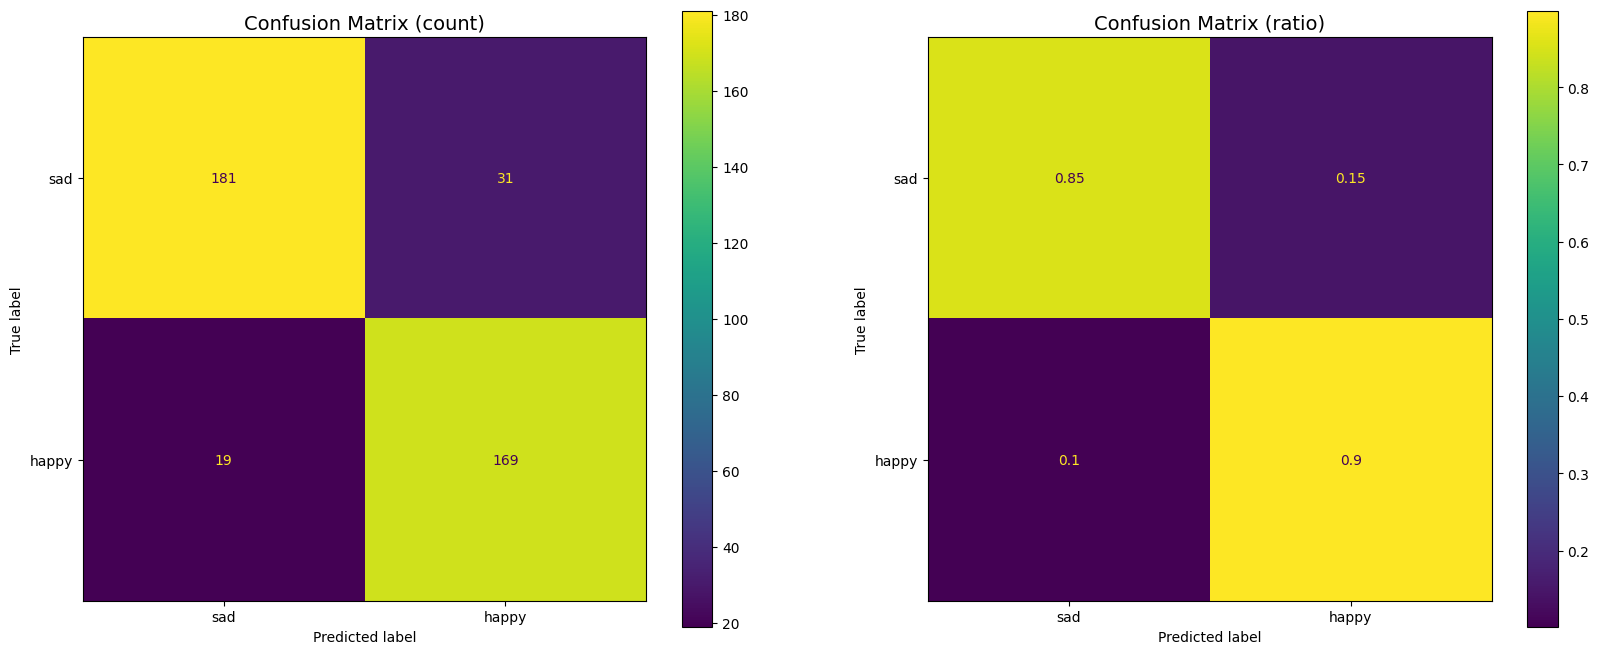

In [66]:
# plot the confusion matrix
confusion_matrix(y_te, prediction)